# Time evolution of the entanglement entroy of a product state

This project is part of the Computational Physics course held at Perimeter, Fall 2018. 

In [1]:
using LinearAlgebra
using Arpack
using Plots

## Product state

In [2]:
function compute_rdmA(PsiAB)
    @assert ndims(PsiAB) == 2 # did we input a matrix?
    @assert size(PsiAB,1) < 2^13 # make sure the resulting matrix is not too large!
    rdm = PsiAB*PsiAB'
end

function compute_entropy(dm)
    p = eigvals(dm) # we diagonalize and use the eigenvalues. the more Julia way
    # has a problem when the log is very large
    entropy = 0.0
    #entropy = - p'*log2.(p) # problems when p[n] is of order 0 (possibly negative)
    for n in 1:size(p,1)
        if abs(p[n]) > 1e-12
            entropy = entropy - p[n]*log2(p[n])
        end
    end
    entropy
end

compute_entropy (generic function with 1 method)

We use the outer product of 1 spin states to construct a separable state:

\begin{equation}
| \Psi_{\text{sep}} > = |\Psi>_1 \otimes |\Psi>_2 \otimes \cdots \otimes |\Psi>_N
\end{equation}

In [37]:
N=2*5 # > 2

function normalizeVec(Vec)
    Vec = Vec/sqrt(abs(Vec'*Vec)) 
end

# here we implement the outer product
function separable(N)
    PsiInitial= reshape( (randn(2) + im*randn(2))*(randn(2) + im*randn(2))', 2^2 )
    for i in 3:N
        PsiInitial = reshape( PsiInitial*(randn(2) + im*randn(2))', 2^i )
    end
    return normalizeVec(PsiInitial)
end

PsiInitial = separable(N);

In [38]:
# checking separability
nA = Int(N/2) # number spins/qubits in A
nB = Int(N/2) # number of spins/qubits in B

PsiAB = reshape(PsiInitial, (2^(nA),2^(nB)))

rdmA = compute_rdmA(PsiAB)

isapprox(compute_entropy(rdmA), 0, atol=10^-14)  # checking that entropy is zero to 10^-14 accuracy

true

## Time evolution 

To obtain $|\Psi(t)\rangle \equiv \exp (-i t H) |\Psi(0)\rangle$, we can use
 $|\Psi(t+\delta t)\rangle = |\Psi(t)\rangle - i \delta t H |\Psi(t)\rangle$. We want to keep the accuracy within $10^{-5}$ at each time step.
 
We want the code to be able to deal with large spin chains, so we do not want to record the full Hamiltonian matrix.

In [5]:
# Ising model
function buildIsing(theta=pi/4) # Ising model with transverse magnetic field h (critical theta=pi/4 by default)
    X = [0. 1; 1 0]
    Z = [1. 0; 0 -1]
    E = diagm(0=>ones(2))
    XX = kron(X,X)
    HXX = XX
    HZ = kron(Z,E) + kron(E,Z)
    H2 = -(cos(theta)*XX + sin(theta)/2*HZ)
    return H2
end

# Energy shift
theta = pi/4 # critical magnetic field
H2 = buildIsing(theta) # Hamiltonian
D,U = eigen(H2)
shiftE = D[end] 
H2 = H2 - shiftE*diagm(0=>ones(4))

# Sparse multiplication
function multiplyHPsi(Psi, H2) 
    L = length(Psi)  # Dimension of the vector space
    N = convert(Int64,log2(L))  # Number of spins
    HPsi = zeros(L)
    for n=1:N                              # This multiplies by the Hamiltonian H
        Psi = reshape(Psi,(4,2^(N-2)))
        HPsi = reshape(HPsi,(4,2^(N-2)))
        HPsi += H2*Psi                 
        Psi = reshape(Psi,(2,2^(N-1)))
        HPsi = reshape(HPsi,(2,2^(N-1)))
        Psi = permutedims(Psi,(2,1))
        HPsi = permutedims(HPsi,(2,1))
    end
    Psi = reshape(Psi,L)
    HPsi = reshape(HPsi, L)
    return HPsi
end

multiplyHPsi (generic function with 1 method)

In [28]:
# Initialization
init_steps = 1
entropy = zeros(1)
normdiff = zeros(1)
initial_step=1
Nsteps = 0;

N = 2 * 5 
Psi = separable(N);
deltat = 0.00000001

1.0e-8

The for loop implements $|\Psi(t+\delta t)\rangle = |\Psi(t)\rangle - i \delta t H |\Psi(t)\rangle$.

In [29]:
# Loop over the time steps
initial_step += Nsteps
Nsteps = 400000000  # change this number if the entanglement entropy has not reached its plateau 
final_step = initial_step + Nsteps-1

for n=initial_step:final_step
    Psi = Psi .- im * deltat .* multiplyHPsi(Psi,H2)
    if n%800000==0
    normdiff = [normdiff; abs(1 - sqrt(abs(Psi'*Psi)))]
    #Psi = normalizeVec(Psinew)
    PsiAB = reshape(Psi, (2^(Int(N/2)),2^(Int(N/2))))
    rdmA = compute_rdmA(PsiAB)
    entropynew = compute_entropy(rdmA)
    entropy = [entropy; entropynew]
    end
    if n%4000000==0 print(n-initial_step+1, ":", Nsteps, " ") end
end

4000000:400000000 8000000:400000000 12000000:400000000 16000000:400000000 20000000:400000000 24000000:400000000 28000000:400000000 32000000:400000000 36000000:400000000 40000000:400000000 44000000:400000000 48000000:400000000 52000000:400000000 56000000:400000000 60000000:400000000 64000000:400000000 68000000:400000000 72000000:400000000 76000000:400000000 80000000:400000000 84000000:400000000 88000000:400000000 92000000:400000000 96000000:400000000 100000000:400000000 104000000:400000000 108000000:400000000 112000000:400000000 116000000:400000000 120000000:400000000 124000000:400000000 128000000:400000000 132000000:400000000 136000000:400000000 140000000:400000000 144000000:400000000 148000000:400000000 152000000:400000000 156000000:400000000 160000000:400000000 164000000:400000000 168000000:400000000 172000000:400000000 176000000:400000000 180000000:400000000 184000000:400000000 188000000:400000000 192000000:400000000 196000000:400000000 200000000:400000000 204000000:400000000 208000

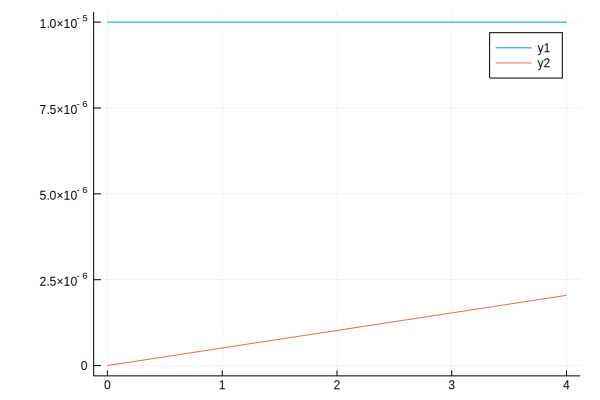

In [30]:
tarray = collect(range(0, stop = deltat * Nsteps, length = length(normdiff)))
standard = [10^-5 for i in 1:length(tarray)]
plot(tarray, standard)
plot!(tarray, normdiff)

## Evolution of the entanglement entropy

We can finally plot the evolution of the entanglement entropy of the half chain with time.

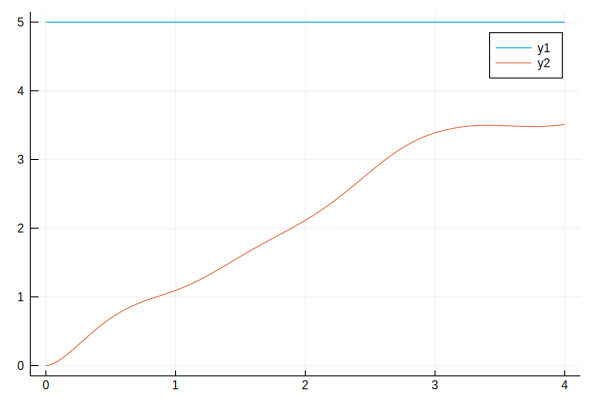

In [31]:
tarray = collect(range(0, stop = deltat * Nsteps, length = length(normdiff)))
asympt = [N/2 for i in 1:length(tarray)]
plot(tarray, asympt)
plot!(tarray, entropy)
#(length(tarray),length(entropy))